In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import glob

# Calibrate the camera.

In [11]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def calibrate(dirpath, prefix, image_format, square_size, width=9, height=6):
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob(dirpath+'/' + prefix + '*.' + image_format)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]
def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

In [12]:
ret, mtx, dist, rvecs, tvecs = calibrate('calibrate_images', 'img', 'jpg', 0.024, 9, 6)
save_coefficients(mtx, dist, '13pro_coef')
print("Calibration is finished. RMS: ", ret)

Calibration is finished. RMS:  8.876811870832384


In [15]:
cap = cv2.VideoCapture('test.mp4')  # Get the camera source
def track(matrix_coefficients, distortion_coefficients):
    while True:
        ret, frame = cap.read()
        # operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Change grayscale
        aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)  # Use 5x5 dictionary to find markers
        parameters = aruco.DetectorParameters_create()  # Marker detection parameters
        # lists of ids and the corners beloning to each id
        corners, ids, rejected_img_points = aruco.detectMarkers(gray, aruco_dict,
                                                                parameters=parameters)
                                                                # cameraMatrix=matrix_coefficients,
                                                                # distCoeff=distortion_coefficients)
        if np.all(ids is not None):  # If there are markers found by detector
            for i in range(0, len(ids)):  # Iterate in markers
                # Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
                rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[i], 0.02, matrix_coefficients,
                                                                           distortion_coefficients)
                (rvec - tvec).any()  # get rid of that nasty numpy value array error
        aruco.drawDetectedMarkers(frame, corners)  # Draw A square around the markers
        aruco.drawAxis(frame, matrix_coefficients, distortion_coefficients, rvec, tvec, 0.01)  # Draw Axis
        # Display the resulting frame
        cv2.imshow('frame', frame)
        # Wait 3 milisecoonds for an interaction. Check the key and do the corresponding job.
        key = cv2.waitKey(3) & 0xFF
        if key == ord('q'):  # Quit
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
track(mtx,dist)

AttributeError: module 'cv2.aruco' has no attribute 'drawAxis'

In [14]:
mtx

array([[3.55852183e+03, 0.00000000e+00, 1.23664944e+03],
       [0.00000000e+00, 3.36627923e+03, 1.71796295e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

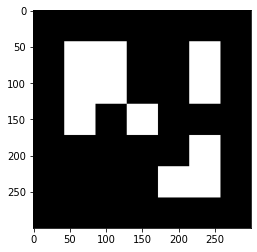

In [6]:
%matplotlib inline
tag = np.zeros((300, 300, 1), dtype="uint8")
dictionary = aruco.Dictionary_get(aruco.DICT_5X5_100)
aruco.drawMarker(dictionary, 24, 300, tag, 1)
plt.figure()
plt.imshow(tag, cmap = plt.cm.gray)

In [3]:
np.unique(tag)


array([  0, 255], dtype=uint8)

In [4]:
cv2.aruco.DICT_5X5_100

5